<a href="https://colab.research.google.com/github/DarvinX/trash_classifier/blob/master/trash_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!unzip dataset.zip

In [0]:
img_height = 192
img_width =  256
model_name = 'model_2.h5'

In [3]:
# %%
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest',
    dtype = 'float32'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                'dataset/train',
                target_size=(img_height, img_width),
                batch_size = 64,
)
validation_generator = test_datagen.flow_from_directory(
                'dataset/validation',
                target_size=(img_height, img_width),
                batch_size=64,
)

Using TensorFlow backend.


Found 2290 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [0]:
# %%
from keras.models import Model
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Input
from keras.optimizers import Adam, Adadelta

input = Input(shape=(img_height, img_width, 3))


x = Conv2D(32, (3,3), activation='relu', padding='same')(input)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(5, activation='softmax')(x)

classifier = Model(input, out)
opt = Adadelta(lr=1.0e-2)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# %%
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 192, 256, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 192, 256, 32)      896       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 192, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 96, 128, 32)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 96, 128, 32)       9248      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 96, 128, 32)       9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 48, 64, 32)        0         
__________

In [0]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath=model_name,monitor='val_acc', verbose=0, save_best_only=True)

In [0]:
# %%
from keras.models import load_model
classifier = load_model(model_name)
hist_classifier = classifier.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs = 100,
        callbacks=[checkpointer],
        validation_data=validation_generator,
        validation_steps=10
)


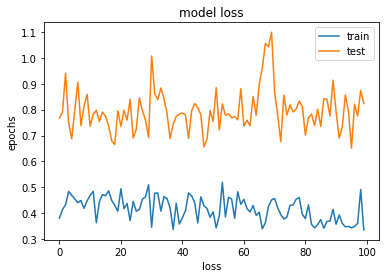

In [97]:
import matplotlib.pyplot as plt

plt.plot(hist_classifier.history['loss'])
plt.plot(hist_classifier.history['val_loss'])
plt.title('model loss')
plt.xlabel('loss')
plt.ylabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [108]:
mod = load_model(model_name)
mod.evaluate_generator(validation_generator, steps=10)[1] #just the accuracy

0.7960000019073487

In [0]:
import glob
from keras.preprocessing.image import img_to_array, load_img

test_input = []
test_path = './dataset/test/trash/'

for path in glob.glob(test_path + '*.jpg'):
  tmp = load_img(path, target_size=(img_height,img_width))
  tmp = img_to_array(tmp)
  tmp = tmp.astype(dtype='float32')
  tmp /= 255
  test_input.append(tmp)

In [0]:
import numpy as np

test_input = np.reshape(test_input, (-1,img_height,img_width,3))
output_data = mod.predict(test_input)
test_predict = np.argmax(output_data, axis=1)

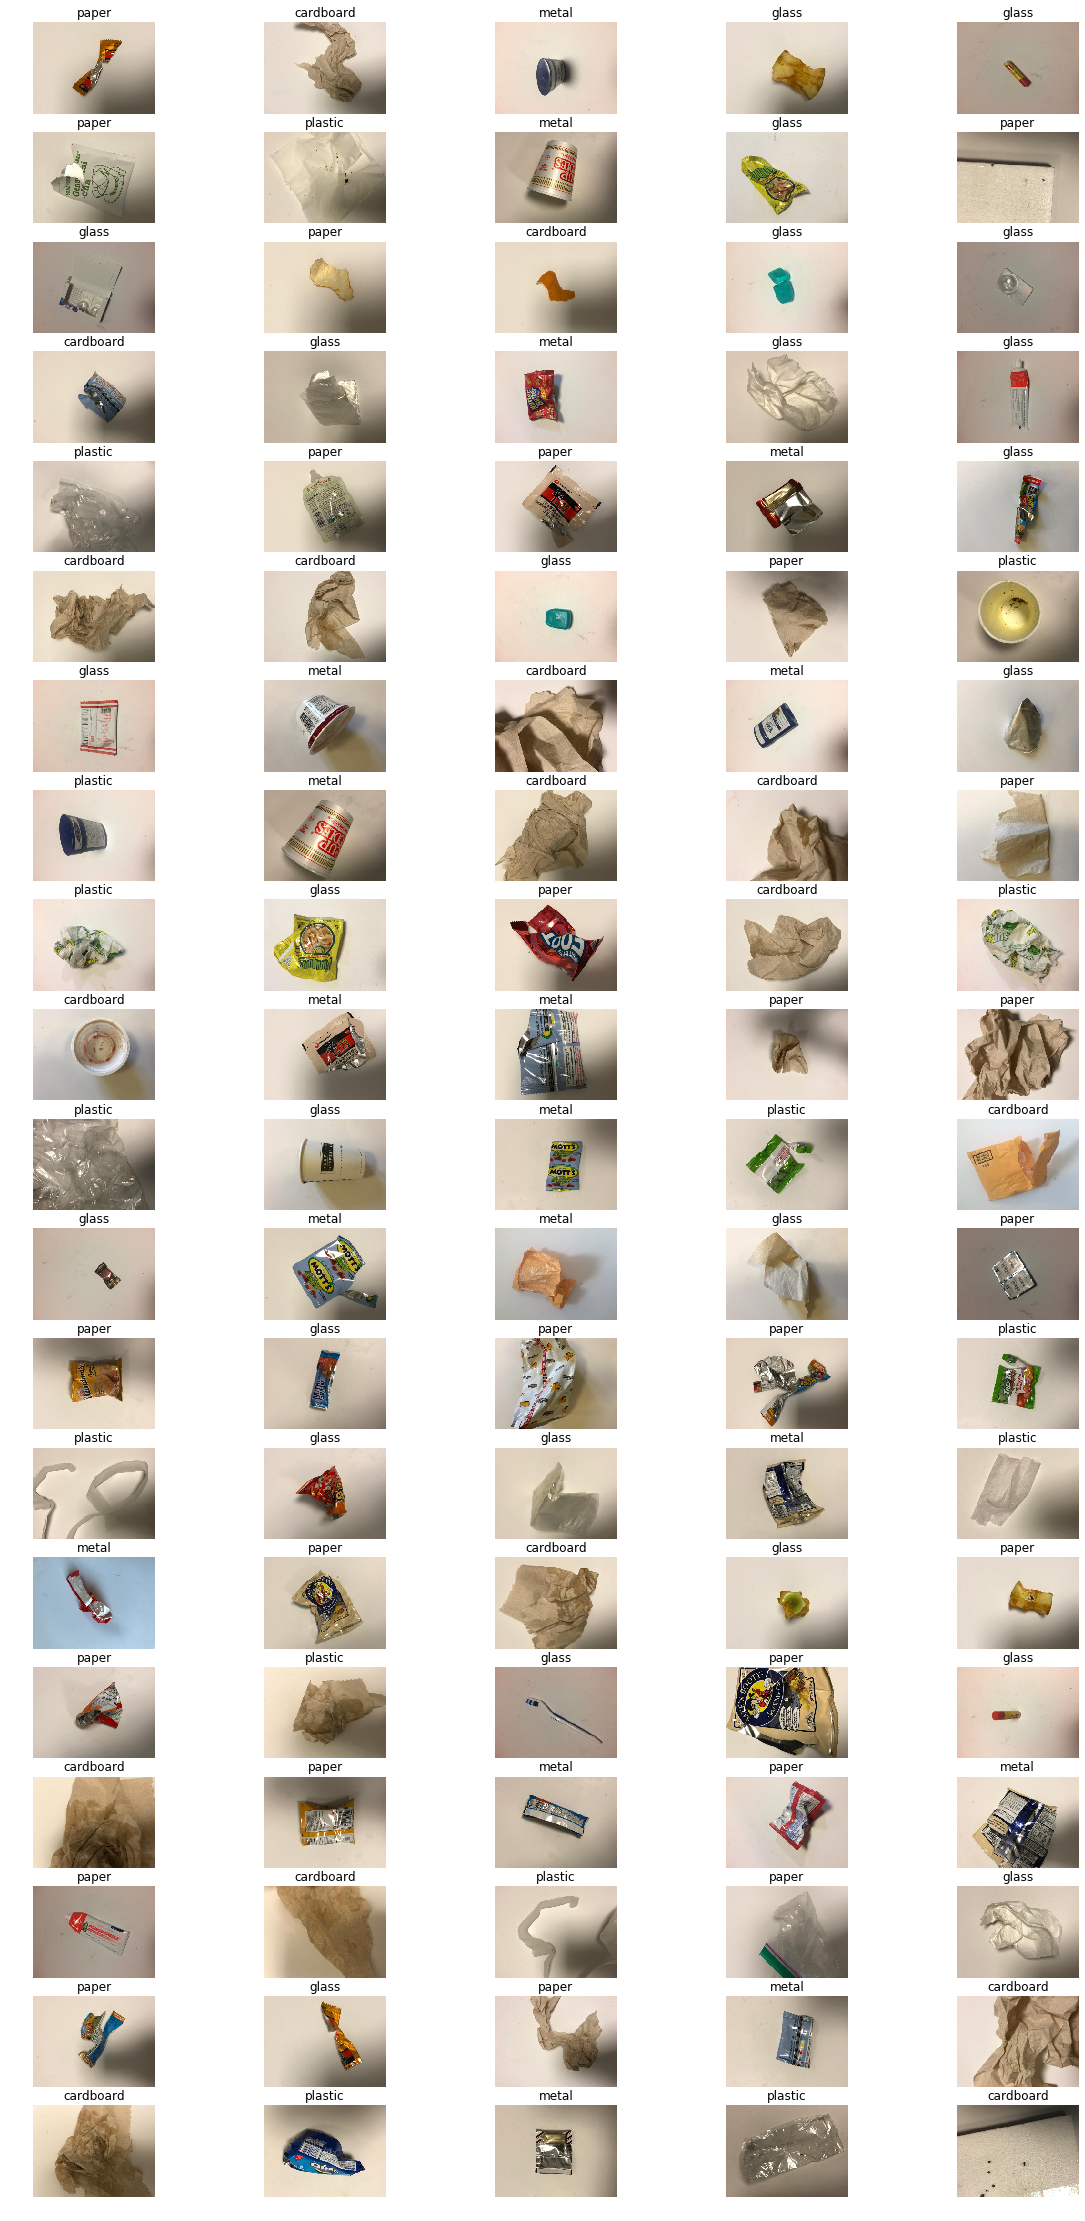

In [101]:
from keras.preprocessing.image import array_to_img

label_name = ['cardboard','glass','metal','paper','plastic']

plt.figure(figsize=(20,40))
for img in range(np.shape(output_data)[0]):
  plt.subplot(20, 5, img+1)
  plt.axis('off')
  plt.title(label_name[test_predict[img]])
  plt.imshow(array_to_img(test_input[img]))
  if img == 99:
    break